In [26]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
    
import sys
sys.path.append(".")

from FastObiwan import * 
import fitsio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
brickname = '2383p305'

In [28]:
!pwd

/global/u2/h/huikong/desc_work/sys_histgram_surveypropertymapfree/code


In [97]:
Obiwan_LRG = fitsio.read("/global/cfs/cdirs/desi/survey/catalogs/image_simulations/LRG/NGC/Obiwan_LRGs.fits", \
                         columns = ["brickname", "sim_ra", "sim_dec", "sim_gflux", "sim_rflux", "sim_zflux", \
                                    "sim_w1", "mw_transmission_w1", "sim_rhalf", "sim_e1", "sim_e2","sim_sersic_n",\
                                    'nobs_g', 'nobs_r', 'nobs_z', 'psfdepth_g', 'psfdepth_r', 'psfdepth_z','ra','dec','flux_z','flux_r'])

In [98]:
Obiwan_LRG = Obiwan_LRG[Obiwan_LRG['brickname'] == brickname]
Obiwan_LRG[0]['psfdepth_g'], Obiwan_LRG[0]['psfdepth_r'], Obiwan_LRG[0]['psfdepth_z']

(1048.3757, 534.66943, 36.04674)

In [63]:


#loop here
brickname = '2383p305'
Obiwan_LRG = Obiwan_LRG[Obiwan_LRG['brickname'] == brickname]

Obiwan_Fast = LegacysurveyCCDList(brickname)
Obiwan_Fast.read_sim_gal( Obiwan_LRG ) 

L_sim = len( Obiwan_Fast.ra )

catalog = []
#loop here
print(L_sim)

import time

start_time = time.time()



for i in range(0,1):
    print( i )
    
    psfdepth_g = 0
    psfdepth_r = 0
    psfdepth_z = 0
    nobs_g = 0
    nobs_r = 0
    nobs_z = 0

    Obiwan_Fast.get_source(i)
   
    L_CCDs = len( Obiwan_Fast.ccd_list)
    tims = []
    for j in range(L_CCDs):
        Obiwan_Fast.init_one_ccd(j)
        Obiwan_Fast.set_local()
        #delte the images that does not fully overlap with this blob?
        if Obiwan_Fast.x_cen_int<10 or Obiwan_Fast.x_cen_int>=Obiwan_Fast.ccd_width-10 or Obiwan_Fast.y_cen_int<10 or Obiwan_Fast.y_cen_int>=Obiwan_Fast.ccd_height-10:
              #this source does not overlap this ccd
              continue
        if Obiwan_Fast.camera != 'decam':
            continue
        #print( Obiwan_Fast.x_cen_int, Obiwan_Fast.y_cen_int, Obiwan_Fast.filter,Obiwan_Fast.camera)
        Obiwan_Fast.gaussian_background()
        Obiwan_Fast.resample_image()
        Obiwan_Fast.resample_psf()
        Obiwan_Fast.finalize_tim()
        tim_j = Obiwan_Fast.final_tim
        tims.append(tim_j)
        
        if Obiwan_Fast.filter == 'g':
            psfdepth_g += Obiwan_Fast.psfdetiv
            nobs_g += 1
        if Obiwan_Fast.filter == 'r':
            psfdepth_r += Obiwan_Fast.psfdetiv
            nobs_r += 1
        if Obiwan_Fast.filter == 'z':
            psfdepth_z += Obiwan_Fast.psfdetiv
            nobs_z += 1

        
        #print(Obiwan_Fast.gain, Obiwan_Fast.zpscale, Obiwan_Fast.sig1,Obiwan_Fast.nano2e)
        #make a guess src that deviates from the true flux
    guess_src = Obiwan_Fast.source_i.copy()
    guess_src.brightness.g = Obiwan_Fast.source_i.brightness.g*(1+np.random.normal()*0.1)
    guess_src.brightness.r = Obiwan_Fast.source_i.brightness.r*(1+np.random.normal()*0.1)
    guess_src.brightness.z = Obiwan_Fast.source_i.brightness.z*(1+np.random.normal()*0.1)
    if Obiwan_Fast.source_i.getSourceType() == 'SersicGalaxy':
        if Obiwan_Fast.source_i.sersicindex.val < 0.3:
            guess_src.sersicindex = LegacySersicIndex(0.3)
        if Obiwan_Fast.source_i.sersicindex.val > 5.3:
            guess_src.sersicindex = LegacySersicIndex(5.3)
    new_tractor = Tractor( tims, [guess_src])
    new_tractor.freezeParam('images')
    #end_time = time.time()
    #print(f"Elapsed time: {elapsed_minutes:.2f} minutes")
    for i in range(50):
        dlnp,X,alpha = new_tractor.optimize()
        #print('dlnp', dlnp)
        if dlnp < 1e-3:
            break
    catalog.append( new_tractor.catalog[0] )

end_time2 = time.time()
elapsed_time = end_time2 - end_time

# Convert to minutes
#elapsed_minutes = elapsed_time / 60
#print(f"Elapsed time: {elapsed_minutes:.2f} minutes")

94
0


In [64]:
Obiwan_Fast.pscale

1.0014124242000286

In [65]:
print("depth from this script:")
psfdepth_g, psfdepth_r, psfdepth_z

depth from this script:


(1038.270583640981, 535.590507318468, 35.69738781056809)

In [66]:
print("depth from the same Obiwan LRG:")
idx = 0
Obiwan_LRG[idx]['psfdepth_g'], Obiwan_LRG[idx]['psfdepth_r'], Obiwan_LRG[idx]['psfdepth_z']

depth from the same Obiwan LRG:


(1048.3757, 534.66943, 36.04674)

In [67]:
print("n_obs from the same Obiwan LRG:")
Obiwan_LRG[idx]['nobs_g'], Obiwan_LRG[idx]['nobs_r'], Obiwan_LRG[idx]['nobs_z']

n_obs from the same Obiwan LRG:


(2, 3, 2)

In [68]:
print("n_obs from the same Obiwan LRG:")
nobs_g, nobs_r, nobs_z

n_obs from the same Obiwan LRG:


(2, 3, 2)

In [41]:
brickname = '2383p305'
Obiwan_LRG = Obiwan_LRG[Obiwan_LRG['brickname'] == brickname]

Obiwan_Fast = LegacysurveyCCDList(brickname)
Obiwan_Fast.read_sim_gal( Obiwan_LRG )

Obiwan_Fast.get_source(0)
guess_src = Obiwan_Fast.source_i

In [42]:
guess_src = Obiwan_Fast.source_i.copy()

In [43]:
Obiwan_Fast.get_source(0)
print("true flux")
print( Obiwan_Fast.gflux[0],Obiwan_Fast.rflux[0],Obiwan_Fast.zflux[0] )

true flux
0.65924746 1.8840947 4.1069384


In [53]:
Obiwan_Fast.get_source(0)

Obiwan_Fast.source_i.brightness.g = Obiwan_Fast.source_i.brightness.g*(1+np.random.normal()*0.5)
Obiwan_Fast.source_i.brightness.r = Obiwan_Fast.source_i.brightness.r*(1+np.random.normal()*0.5)
Obiwan_Fast.source_i.brightness.z = Obiwan_Fast.source_i.brightness.z*(1+np.random.normal()*0.5)

In [54]:
print("guess flux")
print("initial condition has 50% gaussian noise")
Obiwan_Fast.source_i.brightness.g,Obiwan_Fast.source_i.brightness.r,Obiwan_Fast.source_i.brightness.z

guess flux
initial condition has 50% gaussian noise


(0.5691939135598366, 2.25869606418996, 1.83578128317928)

In [55]:
new_tractor = Tractor( tims, [Obiwan_Fast.source_i])
new_tractor.freezeParam('images')

In [56]:
for i in range(50):
    dlnp,X,alpha = new_tractor.optimize()
    print('dlnp', dlnp)
    if dlnp < 1e-3:
        break

dlnp 91.9423333485338
dlnp 0.667220340646054
dlnp 0.09578170924396545
dlnp 0.0078054524083199794
dlnp 0.0008288106528198114


In [57]:
print("fitted flux")
new_tractor.catalog[0].brightness.g,\
new_tractor.catalog[0].brightness.r,\
new_tractor.catalog[0].brightness.z

fitted flux


(0.6528065917046801, 1.9013217150242567, 4.273822464940373)

In [58]:
new_tractor.catalog[0]

SersicGalaxy(pos=RaDecPos[238.43326789276963, 30.38207669907235], brightness=NanoMaggies: g=23, r=21.8, z=20.9, shape=re=0.58981, e1=-0.134797, e2=0.212996, sersicindex=1.172)

In [50]:
Obiwan_Fast.get_source(0)
print("initial condition has 5% gaussian noise")
Obiwan_Fast.source_i.brightness.g = Obiwan_Fast.source_i.brightness.g*(1+np.random.normal()*0.05)
Obiwan_Fast.source_i.brightness.r = Obiwan_Fast.source_i.brightness.r*(1+np.random.normal()*0.05)
Obiwan_Fast.source_i.brightness.z = Obiwan_Fast.source_i.brightness.z*(1+np.random.normal()*0.05)

print("guess flux")
Obiwan_Fast.source_i.brightness.g,Obiwan_Fast.source_i.brightness.r,Obiwan_Fast.source_i.brightness.z

initial condition has 5% gaussian noise
guess flux


(0.6550778189596467, 2.0672460786005193, 4.255093954561581)

In [51]:
new_tractor = Tractor( tims, [Obiwan_Fast.source_i])
new_tractor.freezeParam('images')

for i in range(50):
    dlnp,X,alpha = new_tractor.optimize()
    print('dlnp', dlnp)
    if dlnp < 1e-5:
        break

dlnp 12.647871515737734
dlnp 0.3386390363089049
dlnp 0.012082129735972558
dlnp 0.001403811131240218
dlnp 0.00013009097528993152
dlnp 1.2277243513381109e-05
dlnp 2.4521455088688526e-06


In [52]:
print("fitted flux")
new_tractor.catalog[0].brightness.g,\
new_tractor.catalog[0].brightness.r,\
new_tractor.catalog[0].brightness.z

fitted flux


(0.6530170675315332, 1.9019771223568829, 4.275127796762296)

90 prime


Text(0.5, 1.0, 'Invvar')

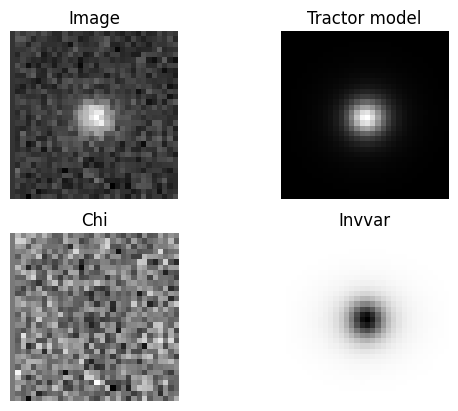

In [310]:
# Get the fit model and residual images for plotting
ima = dict(interpolation='nearest', origin='lower', cmap='gray')

image = tims[1].data
mod = new_tractor.getModelImage(1)
chi = new_tractor.getChiImage(1)
invvar = tims[1].invvar

print("90 prime")
# Plots
plt.clf()
plt.subplot(2,2,1)
plt.imshow(image, **ima)
plt.axis('off')
plt.title('Image')
plt.subplot(2,2,2)
plt.imshow(mod, **ima)
plt.axis('off')
plt.title('Tractor model')
plt.subplot(2,2,3)
plt.imshow(chi, **ima)
plt.axis('off')
plt.title('Chi')
plt.subplot(2,2,4)
plt.imshow(invvar, **ima)
plt.axis('off')
plt.title('Invvar')

In [92]:
dat = fits.getdata("test2.fits")

In [93]:
dat.columns

ColDefs(
    name = 'ra'; format = 'D'
    name = 'dec'; format = 'D'
    name = 'flux_g'; format = 'D'
    name = 'flux_r'; format = 'D'
    name = 'flux_z'; format = 'D'
    name = 'e1'; format = 'D'
    name = 'e2'; format = 'D'
    name = 'shape_r'; format = 'D'
    name = 'sersic'; format = 'D'
)

(array([ 2.,  0.,  1.,  1., 27., 42., 17.,  2.,  0.,  2.]),
 array([-1.96957015, -1.57316761, -1.17676508, -0.78036255, -0.38396002,
         0.01244251,  0.40884505,  0.80524758,  1.20165011,  1.59805264,
         1.99445517]),
 <BarContainer object of 10 artists>)

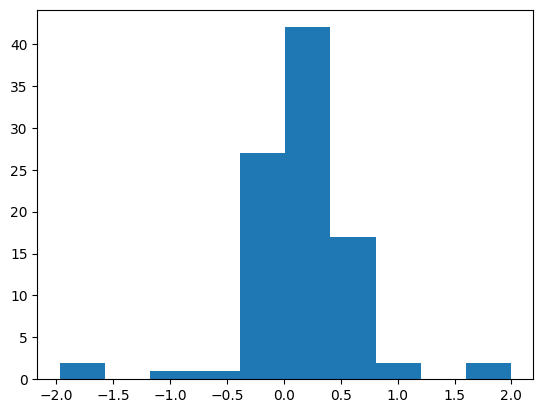

In [94]:
plt.hist( dat['flux_z'] - Obiwan_LRG['sim_zflux'] )

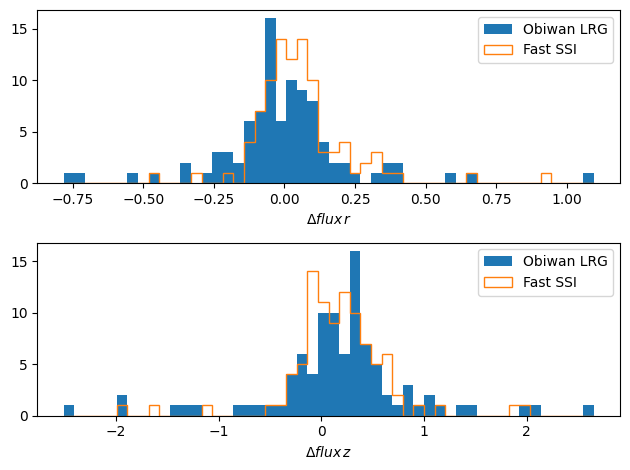

In [107]:
plt.subplot(2,1,1)
n, bins, _ = plt.hist( Obiwan_LRG['flux_r'] - Obiwan_LRG['sim_rflux']+0.03, bins = 50 , label = 'Obiwan LRG')
p=plt.hist( dat['flux_r'] - Obiwan_LRG['sim_rflux'], bins = bins, histtype = 'step' , label = 'Fast SSI')
plt.legend()
plt.xlabel(r'$\Delta flux\, r$')

plt.subplot(2,1,2)
n, bins, _ = plt.hist( Obiwan_LRG['flux_z'] - Obiwan_LRG['sim_zflux']+0.27, bins = 50 , label = 'Obiwan LRG')
p=plt.hist( dat['flux_z'] - Obiwan_LRG['sim_zflux'], bins = bins, histtype = 'step' , label = 'Fast SSI')
plt.legend()
plt.xlabel(r'$\Delta flux\, z$')

plt.tight_layout()

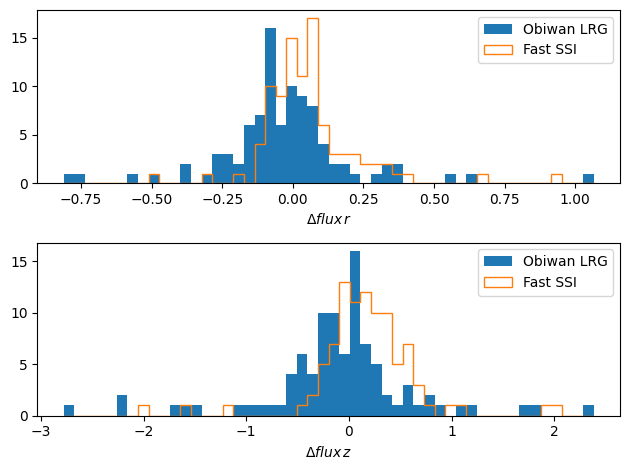

In [108]:
plt.subplot(2,1,1)
n, bins, _ = plt.hist( Obiwan_LRG['flux_r'] - Obiwan_LRG['sim_rflux'], bins = 50 , label = 'Obiwan LRG')
p=plt.hist( dat['flux_r'] - Obiwan_LRG['sim_rflux'], bins = bins, histtype = 'step' , label = 'Fast SSI')
plt.legend()
plt.xlabel(r'$\Delta flux\, r$')

plt.subplot(2,1,2)
n, bins, _ = plt.hist( Obiwan_LRG['flux_z'] - Obiwan_LRG['sim_zflux'], bins = 50 , label = 'Obiwan LRG')
p=plt.hist( dat['flux_z'] - Obiwan_LRG['sim_zflux'], bins = bins, histtype = 'step' , label = 'Fast SSI')
plt.legend()
plt.xlabel(r'$\Delta flux\, z$')

plt.tight_layout()